In [7]:
# Generating course range of parameter space with fixed tage values in Gyrs

In [8]:
from matplotlib.pyplot import *
import numpy as np
from prospectFunctions import *
import itertools
import astropy.units as u
import astropy.constants as const
import time
from tqdm import tqdm

In [9]:
start = time.time()

grid_ranges, run_params = getParams()
a = 1.0 + run_params['zred']

logzs = grid_ranges['logzsol']
dusts = grid_ranges['dust2']
tages = grid_ranges['tage']

obs = getObs(**run_params)
sps = getSps(**run_params)
wspec, wphot = getWave(obs=obs, sps=sps, **run_params)

In [10]:
data_grid_params = np.empty((len(grid_ranges['logzsol']),len(grid_ranges['dust2']),len(grid_ranges['tage']),5))
data_grid_spec = np.empty((10,1,10,len(wspec)))

end = time.time()
print(end-start)

0.9471452236175537


In [11]:
for i_logz,i_dust,i_tage in tqdm(itertools.product(range(10),range(1),range(10))):
    
    logz = grid_ranges['logzsol'][i_logz]
    dust = grid_ranges['dust2'][i_dust]
    tage = grid_ranges['tage'][i_tage]

    run_params['tage'] = tage
    run_params['dust2'] = dust
    run_params['logzsol'] = logz

    model = getModel(**run_params)
    
    init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

    data_grid_params[i_logz, i_dust, i_tage, :] = [run_params['zred'], run_params['mass'], logz, dust, tage]
    data_grid_spec[i_logz, i_dust, i_tage, :] = init_spec

100it [02:58,  1.78s/it]


In [12]:
data_grid_means_test = np.empty([10,1,10,7])
data_grid_spec_test = np.empty([10,1,10,5994])

In [30]:
init = time.time()

bounds3620 = getBreakBounds(wspec, 3620, **run_params)
blue_3620, blue_3720 = bounds3620['blue'][0], bounds3620['blue'][1]
bounds3850 = getBreakBounds(wspec, 3850, **run_params)
blue_3850, blue_3950 = bounds3850['blue'][0], bounds3850['blue'][1]
red_4000, red_4100 = bounds3850['red'][0], bounds3850['red'][1]

bounds = getBreakBounds(wspec, 4000, **run_params)
blue_l, blue_u = bounds['blue'][0], bounds['blue'][1]

for i_logz, i_dust, i_tage in itertools.product(range(10), range(1), range(10)):

    test_mean = data_grid_spec[i_logz,i_dust,i_tage,blue_l:blue_u].mean()
    data_grid_spec_test[i_logz,i_dust,i_tage,:] = data_grid_spec[i_logz,i_dust,i_tage,:]/test_mean

    mean_3620 = data_grid_spec_test[i_logz, i_dust, i_tage, blue_3620:blue_3720].mean()
    mean_3850 = data_grid_spec_test[i_logz, i_dust, i_tage, blue_3850:blue_3950].mean()
    mean_4000 = data_grid_spec_test[i_logz, i_dust, i_tage, red_4000:red_4100].mean()

    data_grid_means_test[i_logz,i_dust,i_tage,:] = [3670, 4050, 3900, 4050, mean_3620, mean_3850, mean_4000]
    
end = time.time()
print(end-init)

0.013988018035888672


In [31]:
break_strengths = {}

starts = np.linspace(3620, 3850, 231, dtype=int)

for start in starts:
    
    bounds = getBreakBounds(wspec, start, **run_params)
    
    blue_lower, blue_upper = bounds['blue'][0], bounds['blue'][1]
    red_lower, red_upper = bounds['red'][0], bounds['red'][1]
    
    data_grid_break = np.empty((len(logzs),len(dusts),len(tages),1))
    
    for i_logz,i_dust,i_tage in itertools.product(range(len(logzs)),range(len(dusts)),range(len(tages))):
        lower = data_grid_spec[i_logz,i_dust,i_tage,blue_lower:blue_upper].mean()
        upper = data_grid_spec[i_logz,i_dust,i_tage,red_lower:red_upper].mean()
    
        ratio = upper/lower
    
        data_grid_break[i_logz,i_dust,i_tage,:] = ratio
    
    break_strengths[f'data_grid_break_{start}'] = data_grid_break

In [ ]:
i_dust = 0

color = cm.gist_rainbow(np.linspace(0, 1, len(tages)))

bounds = getBreakBounds(wspec, 4000, **run_params)
blue_l, blue_u = bounds['blue'][0], bounds['blue'][1]

y = np.linspace(0,1e10,2)

lower_1 = np.ones(2)*3620
upper_1 = np.ones(2)*3720
lower_2 = np.ones(2)*3850
upper_2 = np.ones(2)*3950
lower_3 = np.ones(2)*4000
upper_3 = np.ones(2)*4100

alpha = 0.6
lw = 1
ls = '--'

for i_logz in range(len(logzs)):

    maxis = []
    minis = []

    fig, ax1 = subplots(1,1, figsize=(16,8))
        
    for i_tage in range(len(tages)):

        test_mean = data_grid_spec[i_logz,i_dust,i_tage,blue_l:blue_u].mean()
    
        ax1.plot(wspec/a, data_grid_spec[i_logz,i_dust,i_tage,:]/test_mean, lw=1, color=color[i_tage], label=f'tage={tages[i_tage]:.2f}', zorder=1)
        maxis.append(data_grid_spec[i_logz,i_dust,i_tage,382:914].max())
        minis.append(data_grid_spec[i_logz,i_dust,i_tage,382:914].min())

    # for i_tage in range(len(tages)):

        # ax1.plot(data_grid_means_test[i_logz,i_dust,i_tage,0:2], data_grid_means_test[i_logz,i_dust,i_tage,[4,6]], marker='^', markersize=4, color=color[i_tage], label=f'tage={tages[i_tage]:.2f}', zorder=2)
        # ax1.plot(data_grid_means_test[i_logz,i_dust,i_tage,2:4], data_grid_means_test[i_logz,i_dust,i_tage,[5,6]], marker='^', markersize=4, color=color[i_tage], zorder=2)

    ax1.plot(lower_1,y,color='purple',ls=ls,lw=lw,alpha=alpha)
    ax1.plot(upper_1,y,color='purple',ls=ls,lw=lw,alpha=alpha)
    
    ax1.plot(lower_2,y,color='blue',ls=ls,lw=lw,alpha=alpha)
    ax1.plot(upper_2,y,color='blue',ls=ls,lw=lw,alpha=alpha)

    ax1.plot(lower_3,y,color='red',ls=ls,lw=lw,alpha=alpha)
    ax1.plot(upper_3,y,color='red',ls=ls,lw=lw,alpha=alpha)
    
    
    # for i_tage in range(len(tages)):
    
    #     # color = cm.rainbow(np.linspace(0, 1, len(logzs)))
    
    #     for start in starts:
        
    #         if start != starts[-1]:
    #             B = break_strengths[f'data_grid_break_{start}'][i_logz,i_dust,i_tage,:]
    #             ax2.scatter(start, B, color=color[i_tage], s=4)
    #         else:
    #             B = break_strengths[f'data_grid_break_{start}'][i_logz,i_dust,i_tage,:]
    #             ax2.scatter(start, B, color=color[i_tage], s=4, label=f'tage={tages[i_tage]:.1f}')
    
    # xlabel(r'Start Rest Frame Wavelength [$\AA$]')
    # ylabel('Break Strength')
    
    # ax2.legend()

    maxis = np.array(maxis)
    minis = np.array(minis)
    
    xmin, xmax = 3000, 4500 #(3610), (4110)

    # yscale('log')
    
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([0,2])
    
    ax1.set_xlabel(r'Rest Frame Wavelength [$\AA$]')
    ax1.set_ylabel(r'Flux Density ($f_\lambda$)')
    
    ax1.legend()

    title_text = f'logzsol={logzs[i_logz]:.1f}, dust2={dusts[i_dust]:.1f}'

    fig.suptitle(title_text)

    # savefig(f"flux_vs_strength_logzsol_{logzs[i_logz]:.1f}.png")
    
    show()

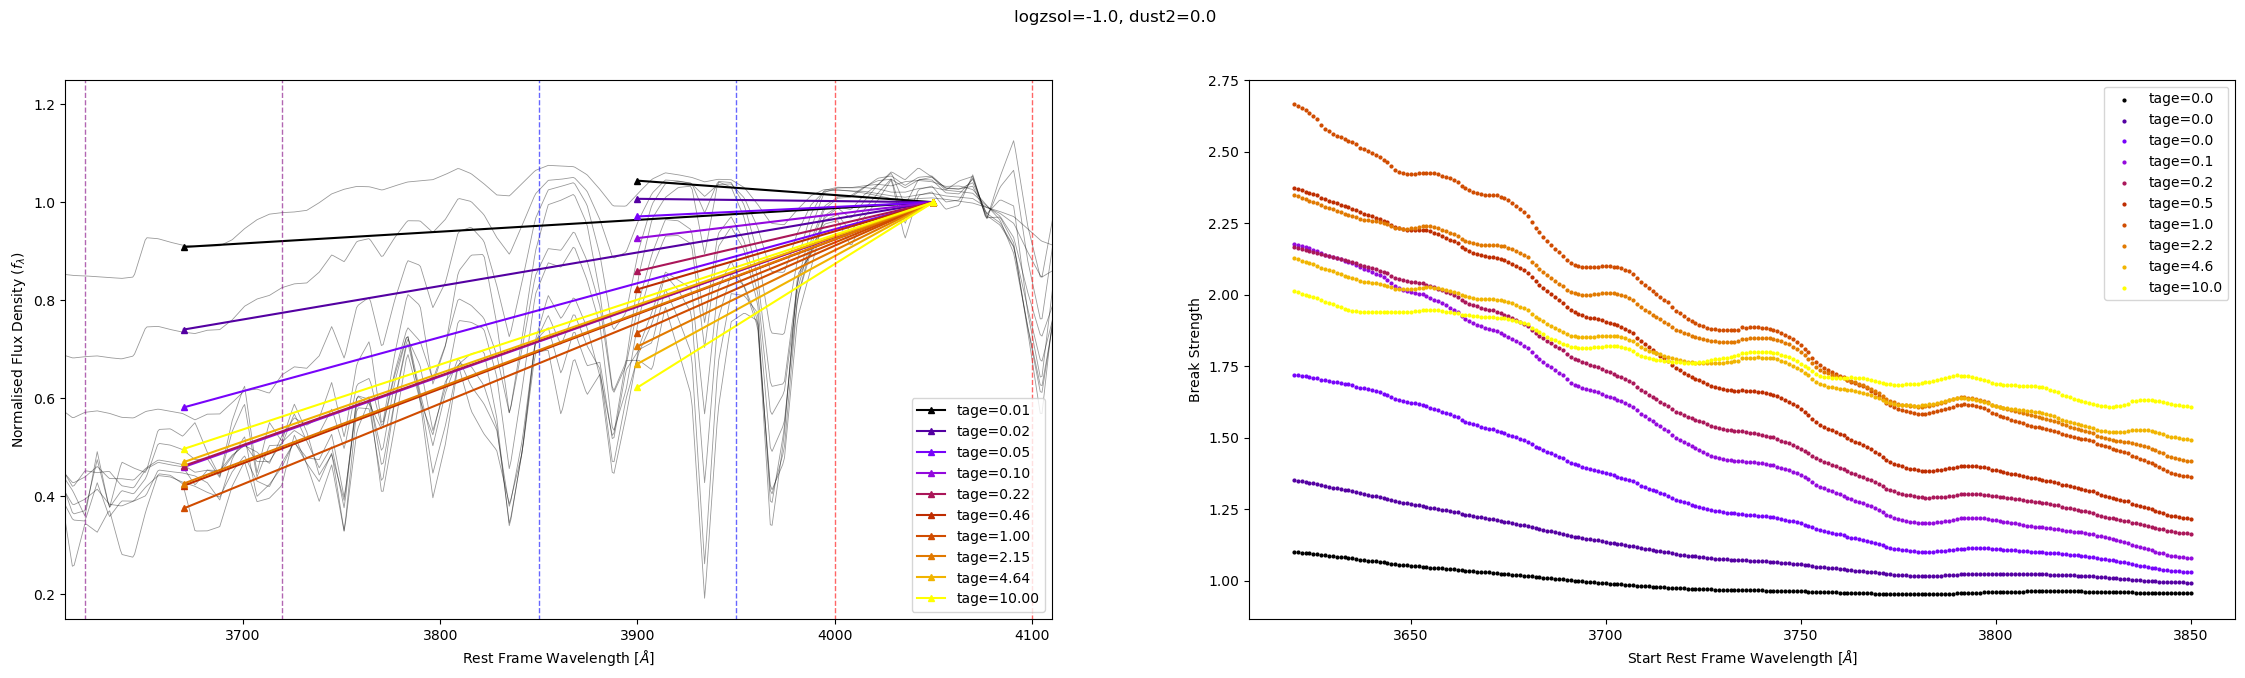

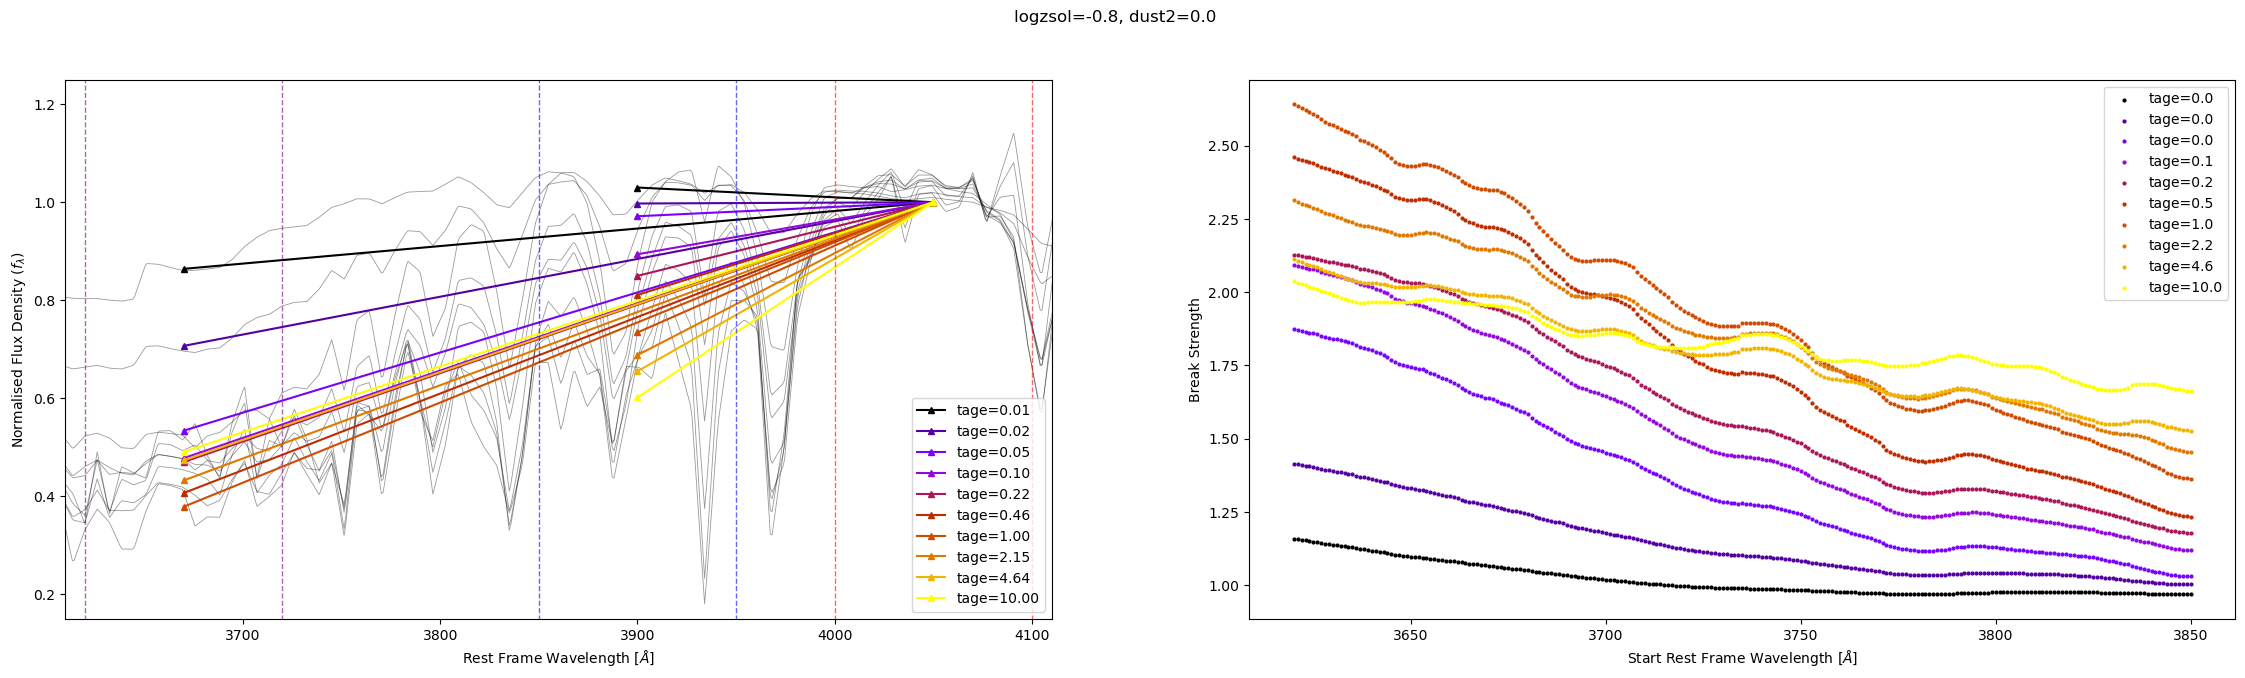

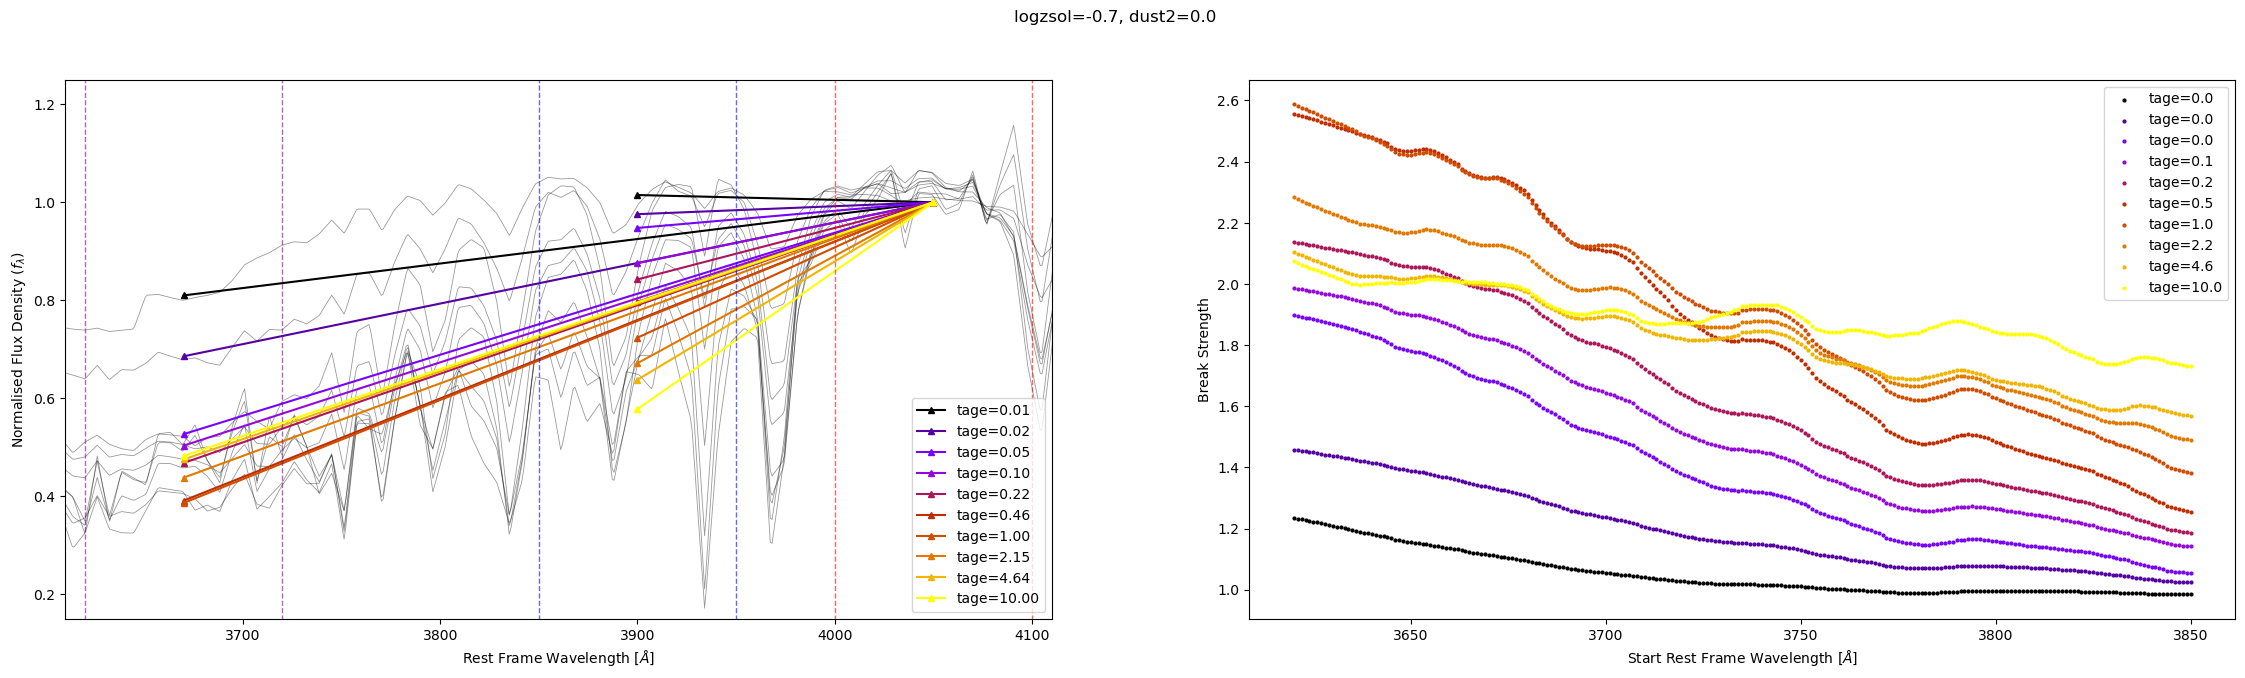

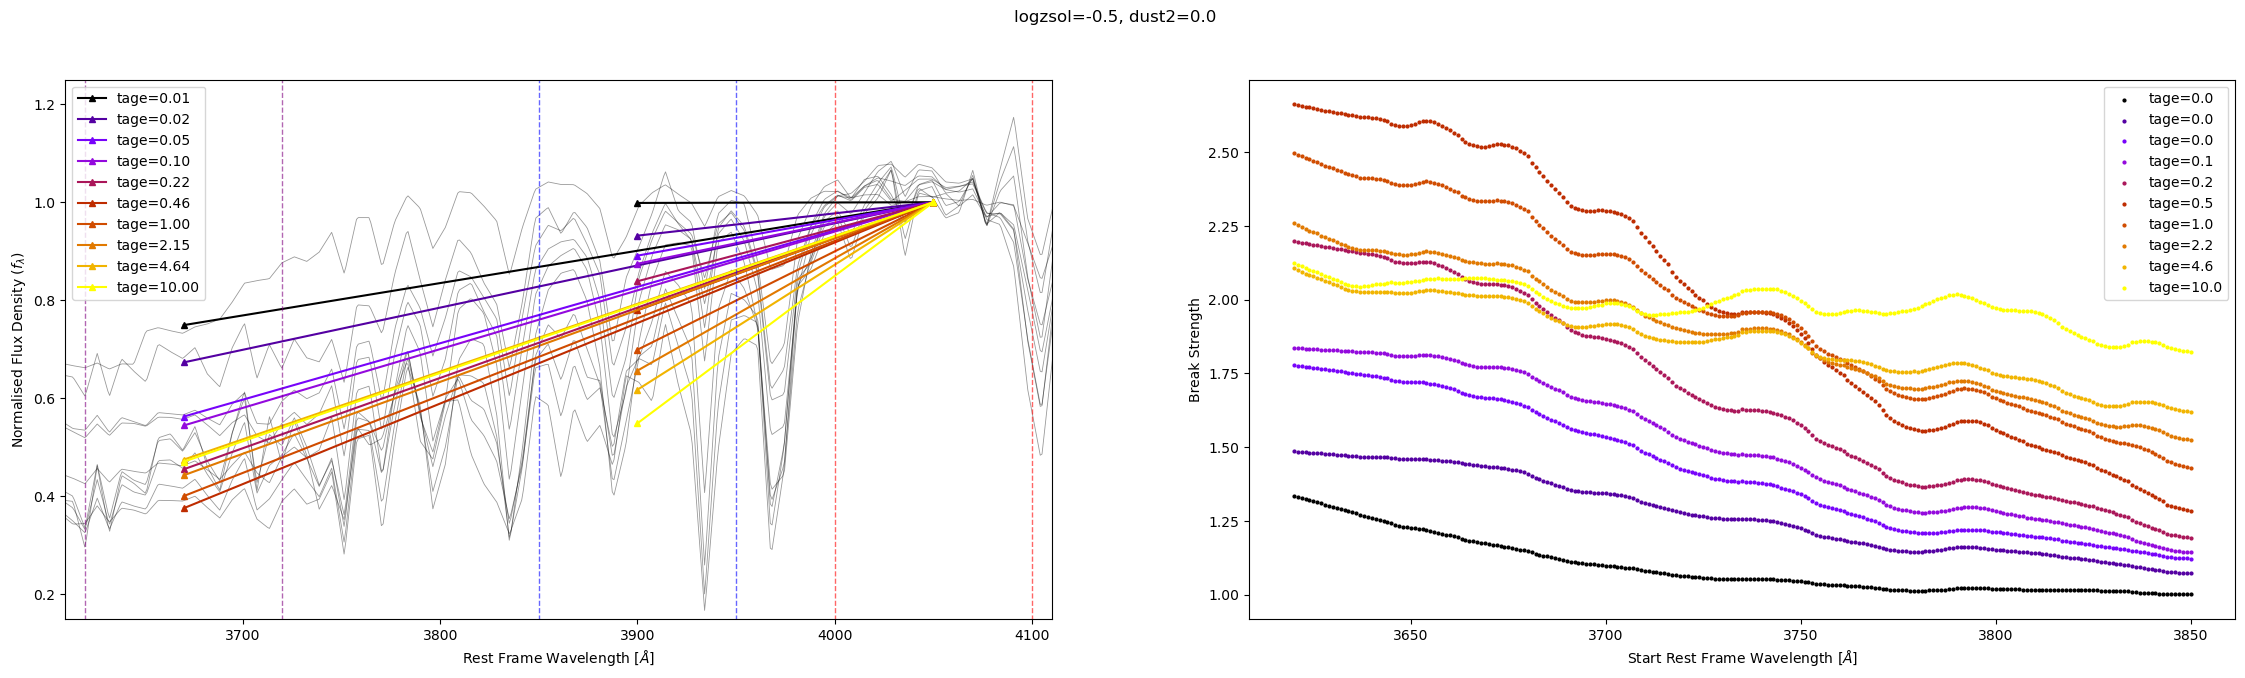

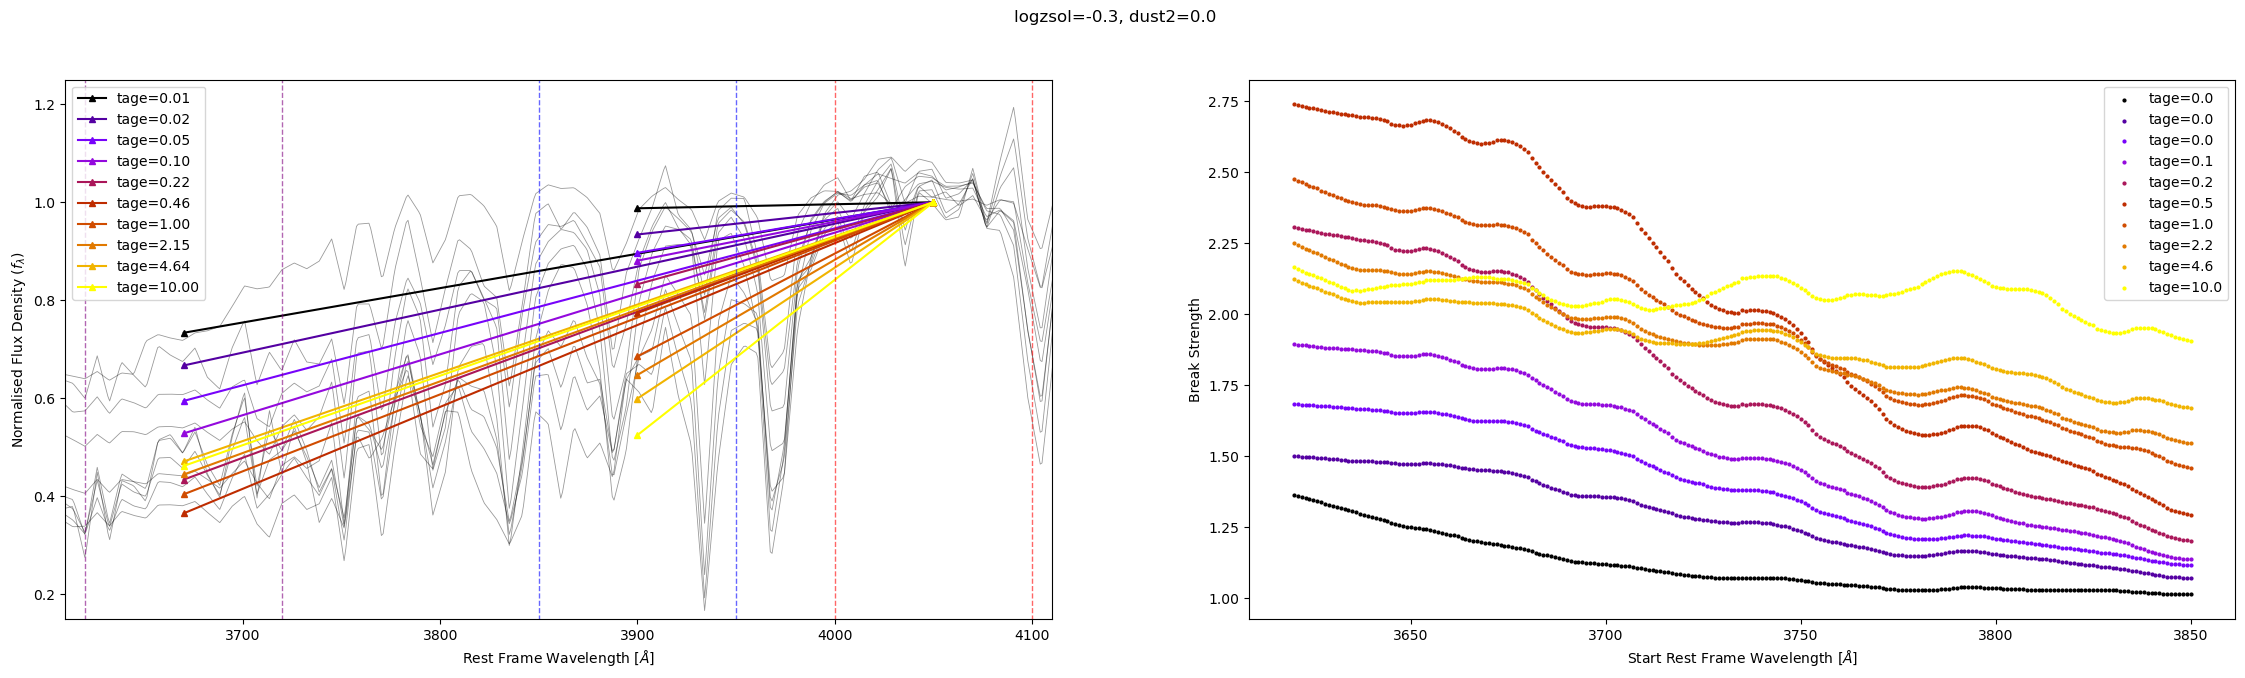

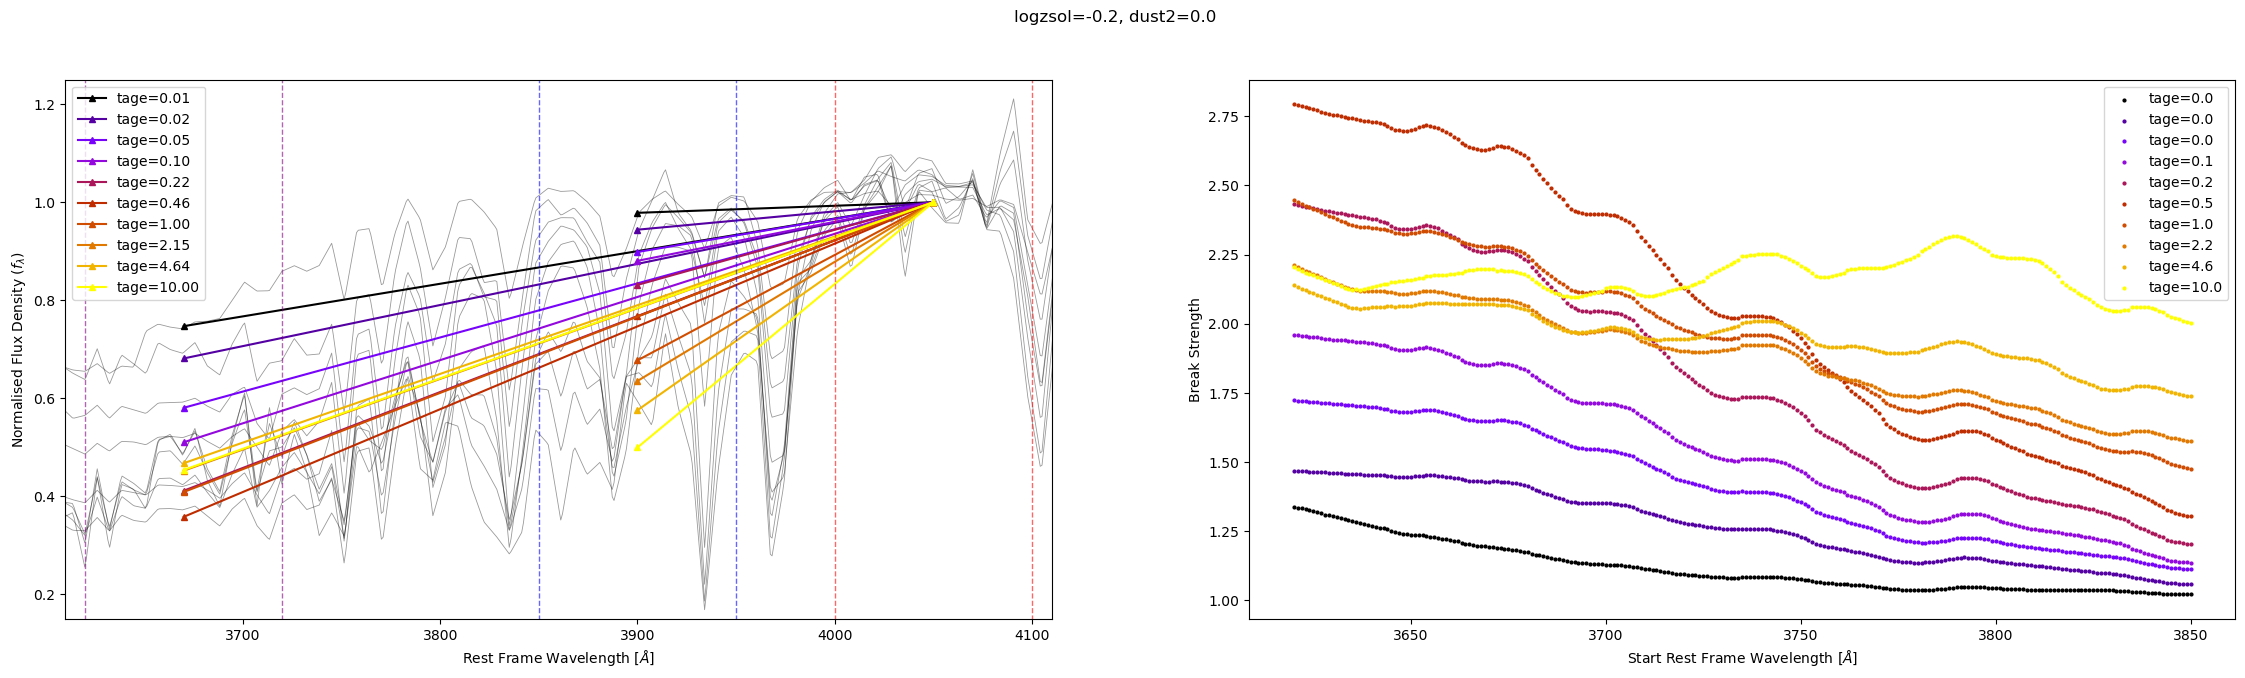

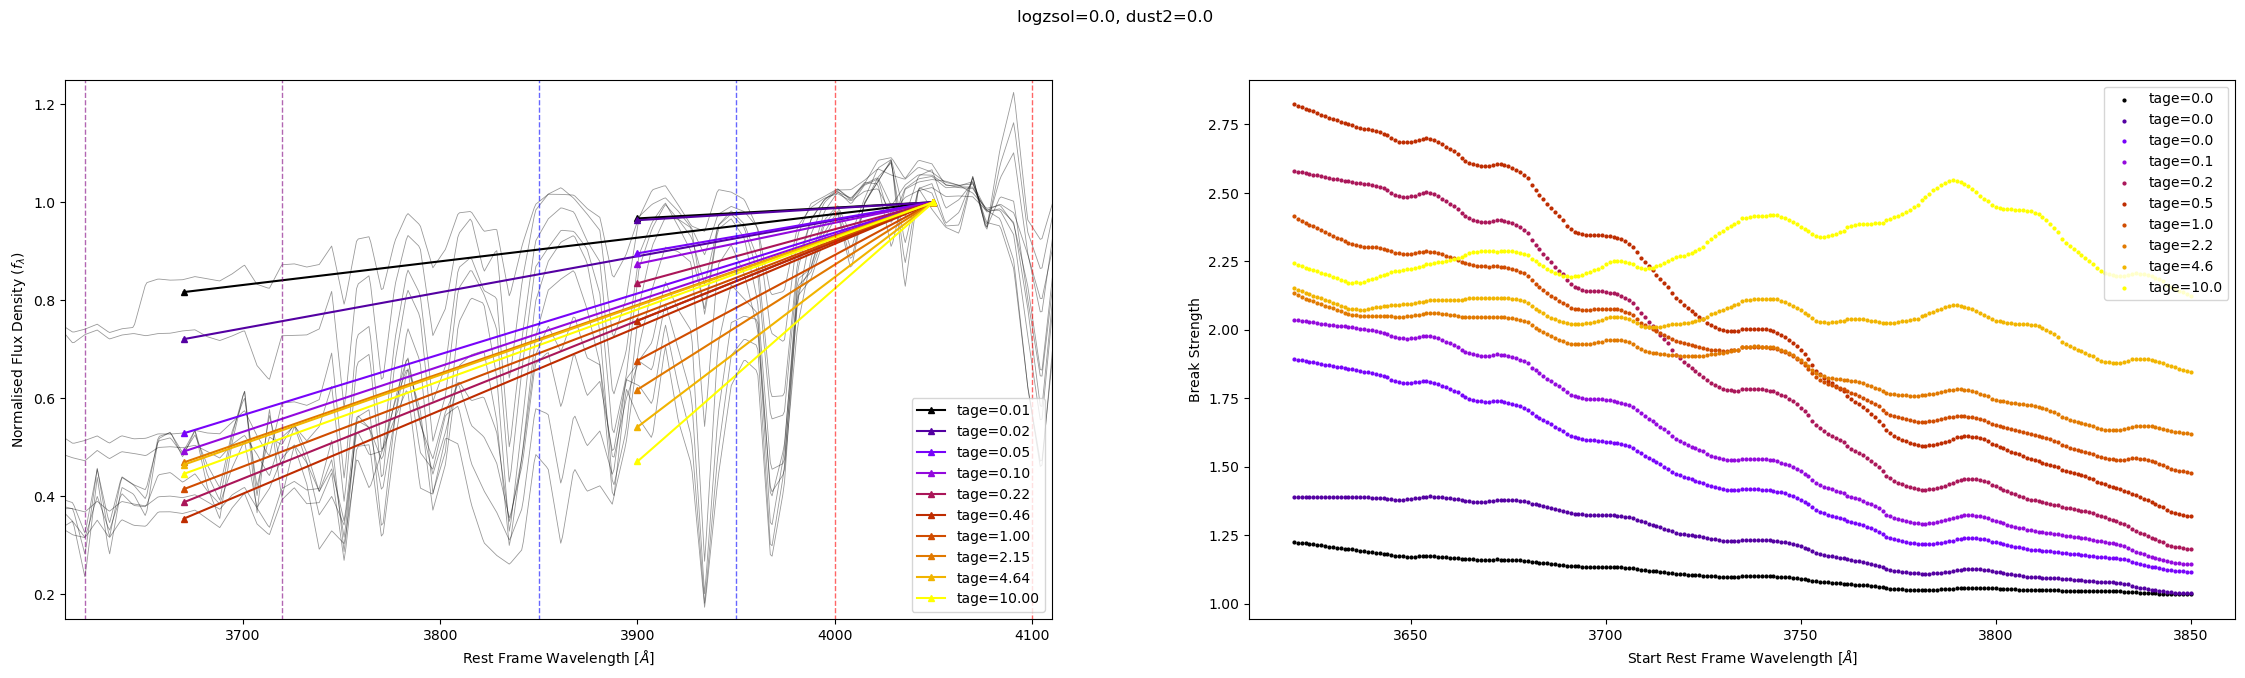

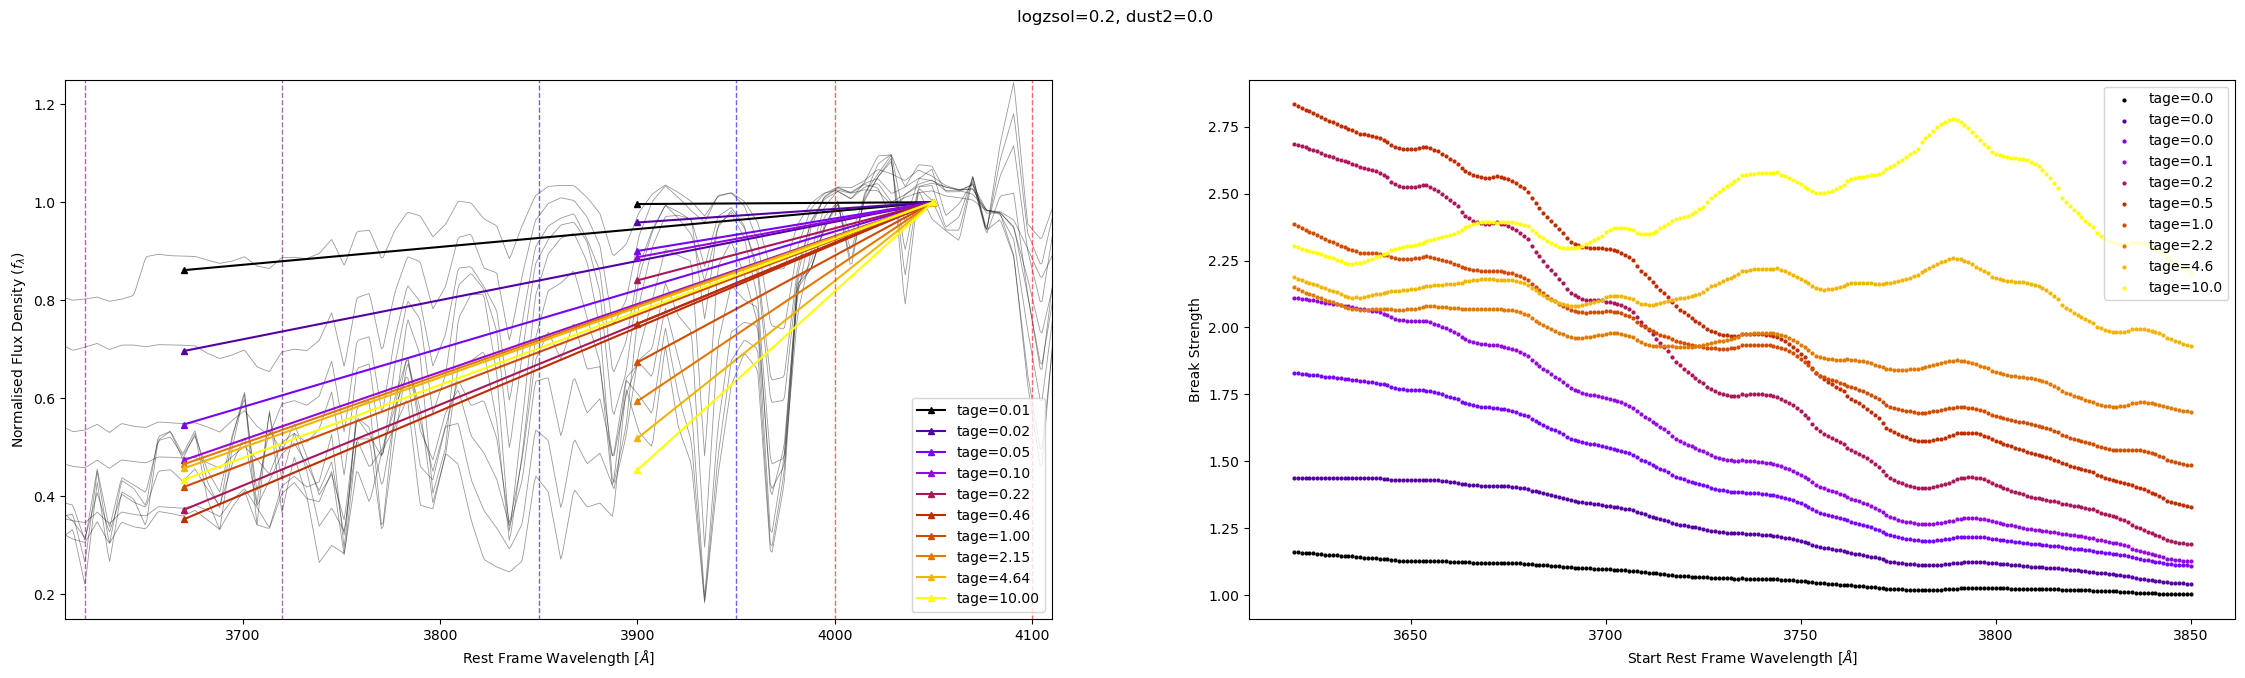

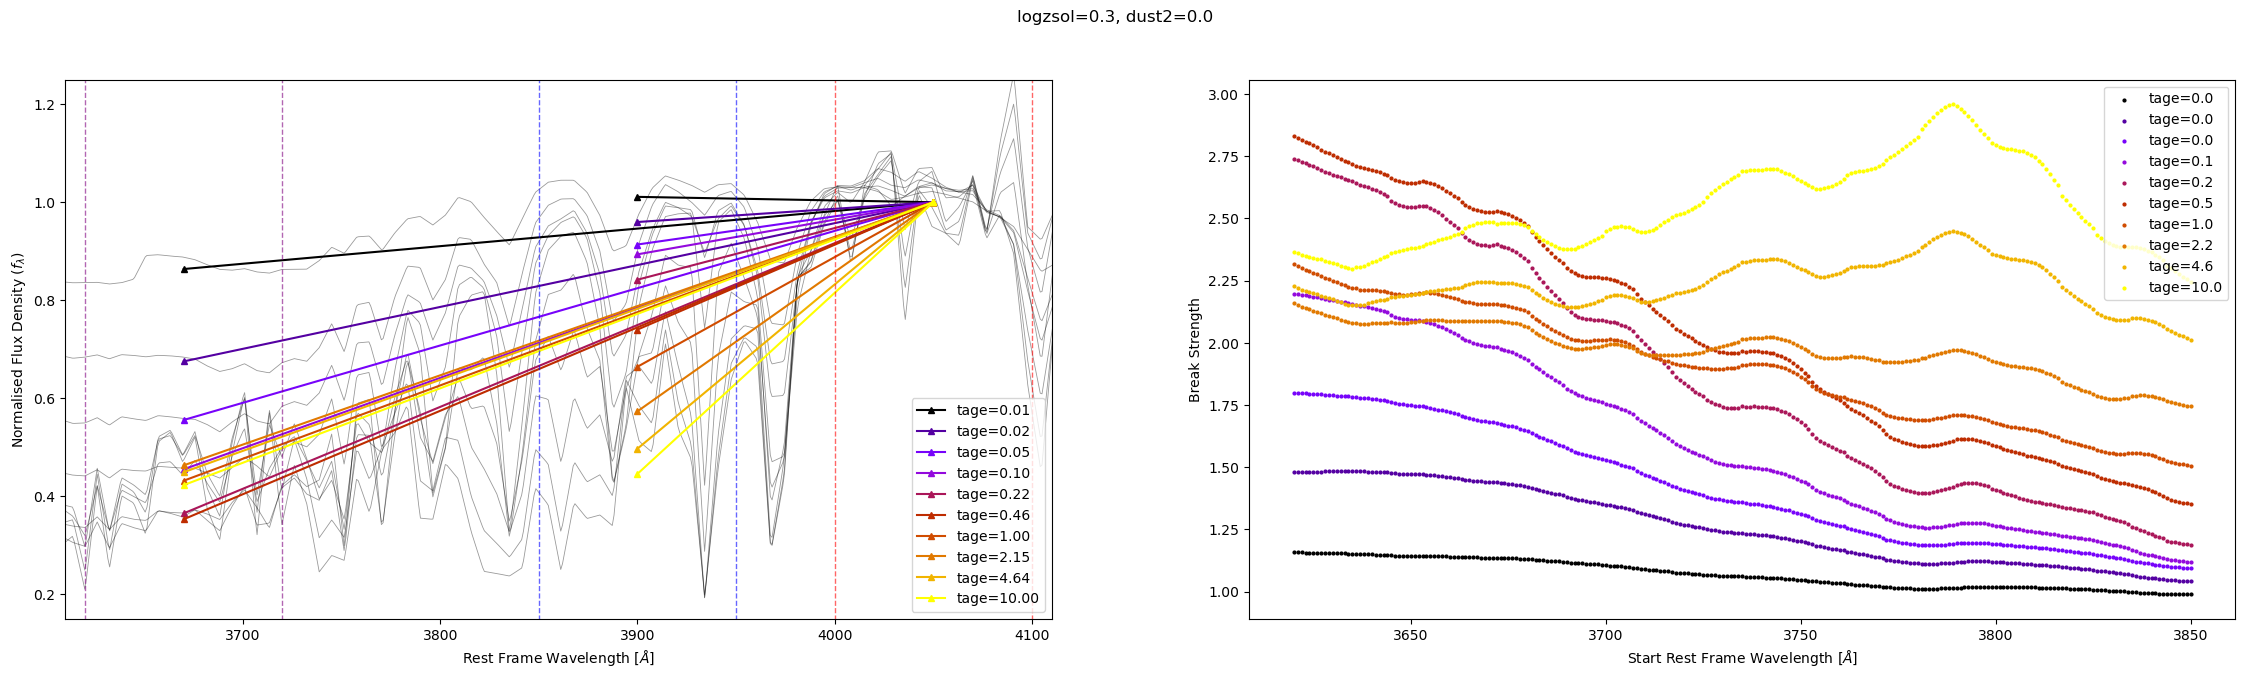

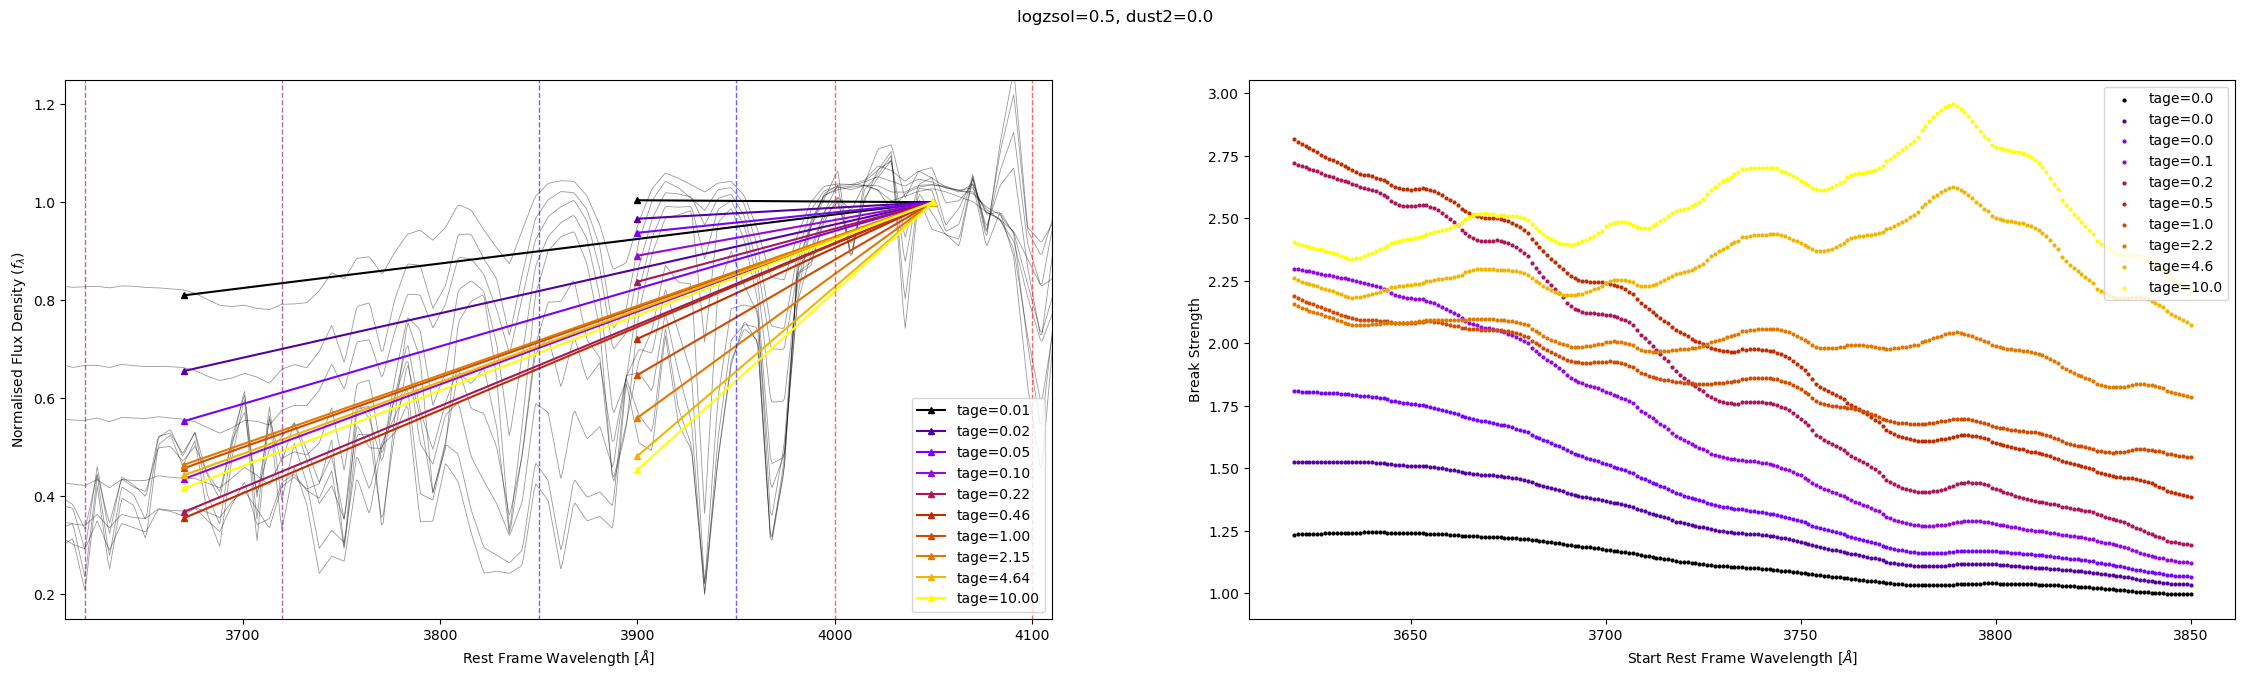

In [35]:
i_dust = 0

color = cm.gnuplot(np.linspace(0, 1, len(tages)))

bounds = getBreakBounds(wspec, 4000, **run_params)
blue_l, blue_u = bounds['blue'][0], bounds['blue'][1]

y = np.linspace(0,1e10,2)

lower_1 = np.ones(2)*3620
upper_1 = np.ones(2)*3720
lower_2 = np.ones(2)*3850
upper_2 = np.ones(2)*3950
lower_3 = np.ones(2)*4000
upper_3 = np.ones(2)*4100

alpha = 0.6
lw = 1
ls = '--'

for i_logz in range(len(logzs)):

    maxis = []
    minis = []

    fig, [ax1, ax2] = subplots(1,2, figsize=(28,7))
        
    for i_tage in range(len(tages)):

        test_mean = data_grid_spec[i_logz,i_dust,i_tage,blue_l:blue_u].mean()
    
        ax1.plot(wspec/a, data_grid_spec[i_logz,i_dust,i_tage,:]/test_mean, lw=.6, alpha=.4, color='black', zorder=1)
        maxis.append(data_grid_spec[i_logz,i_dust,i_tage,382:914].max())
        minis.append(data_grid_spec[i_logz,i_dust,i_tage,382:914].min())

    for i_tage in range(len(tages)):

        ax1.plot(data_grid_means_test[i_logz,i_dust,i_tage,0:2], data_grid_means_test[i_logz,i_dust,i_tage,[4,6]], marker='^', markersize=4, color=color[i_tage], label=f'tage={tages[i_tage]:.2f}', zorder=2)
        ax1.plot(data_grid_means_test[i_logz,i_dust,i_tage,2:4], data_grid_means_test[i_logz,i_dust,i_tage,[5,6]], marker='^', markersize=4, color=color[i_tage], zorder=2)

    ax1.plot(lower_1,y,color='purple',ls=ls,lw=lw,alpha=alpha)
    ax1.plot(upper_1,y,color='purple',ls=ls,lw=lw,alpha=alpha)
    
    ax1.plot(lower_2,y,color='blue',ls=ls,lw=lw,alpha=alpha)
    ax1.plot(upper_2,y,color='blue',ls=ls,lw=lw,alpha=alpha)

    ax1.plot(lower_3,y,color='red',ls=ls,lw=lw,alpha=alpha)
    ax1.plot(upper_3,y,color='red',ls=ls,lw=lw,alpha=alpha)
    
    
    for i_tage in range(len(tages)):
    
        for start in starts:
        
            if start != starts[-1]:
                B = break_strengths[f'data_grid_break_{start}'][i_logz,i_dust,i_tage,:]
                ax2.scatter(start, B, color=color[i_tage], s=4)
            else:
                B = break_strengths[f'data_grid_break_{start}'][i_logz,i_dust,i_tage,:]
                ax2.scatter(start, B, color=color[i_tage], s=4, label=f'tage={tages[i_tage]:.1f}')
    
    xlabel(r'Start Rest Frame Wavelength [$\AA$]')
    ylabel('Break Strength')
    
    ax2.legend()

    maxis = np.array(maxis)
    minis = np.array(minis)
    
    xmin, xmax = (3610), (4110)
    
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([1.5e-1, 12.5e-1])
    
    ax1.set_xlabel(r'Rest Frame Wavelength [$\AA$]')
    ax1.set_ylabel(r'Normalised Flux Density ($f_\lambda$)')
    
    ax1.legend()

    title_text = f'logzsol={logzs[i_logz]:.1f}, dust2={dusts[i_dust]:.1f}'

    fig.suptitle(title_text)

    # savefig(f"flux_vs_strength_logzsol_{logzs[i_logz]:.1f}.png")
    
    show()

------------------------